In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

train_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 200, canonicalize_fmap=None
    )[1]
test_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'test', 200, canonicalize_fmap=None
)[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.54it/s]


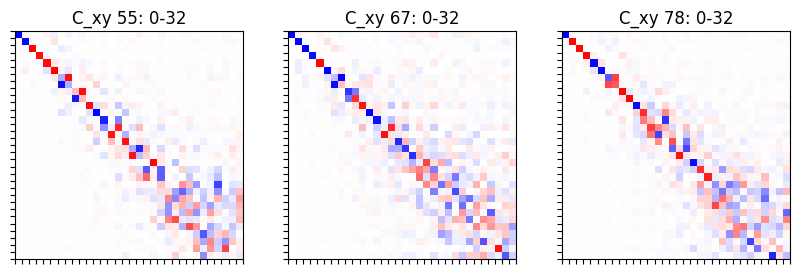

In [49]:
import my_code.utils.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], train_dataset[55]['second']['C_gt_xy'][0],
                        'C_xy 55', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], train_dataset[67]['second']['C_gt_xy'][0],
                        'C_xy 67', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], train_dataset[78]['second']['C_gt_xy'][0],
                        'C_xy 78', l, h, show_grid=False, show_colorbar=False)



plt.show()

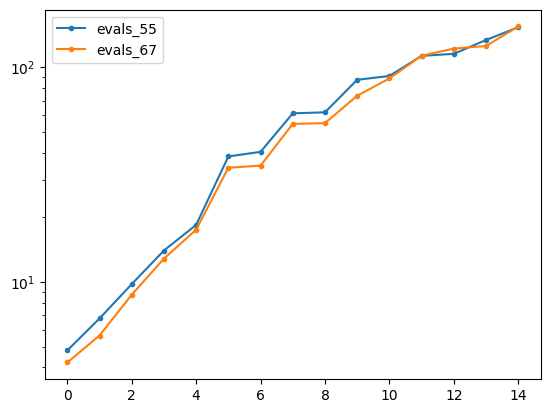

In [50]:
l = 1
h = 16

plt.plot(train_dataset[55]['second']['evals'][0][l:h], '.-', label='evals_55')
plt.plot(train_dataset[67]['second']['evals'][0][l:h], '.-', label='evals_67')
# plt.plot(train_dataset[78]['second']['evals'][0][l:h], '.-', label='evals_78')

plt.legend()
plt.yscale('log')

plt.show()

In [4]:
def predict_sign_change(net, verts, faces, evecs_flip, evecs_cond):
    
    # normalize the evecs
    evecs_flip = torch.nn.functional.normalize(evecs_flip, p=2, dim=1)
    
    if evecs_cond is not None:
        evecs_cond = torch.nn.functional.normalize(evecs_cond, p=2, dim=1)
        evecs_input = torch.cat([evecs_flip, evecs_cond], dim=-1)
    else:
        evecs_input = evecs_flip
        
    # process the flipped evecs
    support_vector_flip = net(
        verts=verts,
        faces=faces,
        feats=evecs_input,
    ) # [1 x 6890 x 1]

    # normalize the support vector
    support_vector_norm = torch.nn.functional.normalize(support_vector_flip, p=2, dim=1)
    
    # multiply the support vector by the flipped evecs [1 x 6890 x 4].T @ [1 x 6890 x 4]
    product_with_support = support_vector_norm.transpose(1, 2) @ evecs_flip

    if product_with_support.shape[1] == product_with_support.shape[2]:
        # take only diagonal elements
        sign_flip_predicted = torch.diagonal(product_with_support, dim1=1, dim2=2)
        
    # get the sign of the support vector
    # sign_flip_predicted = product_with_support
 
    return sign_flip_predicted, support_vector_norm, product_with_support

In [5]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0
feature_dim = 64


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim + condition_dim,
    out_channels=feature_dim,
    # hidden_channels=feature_dim // 2,
    cache_dir=f'data_with_smpl_corr/FAUST_original/{200}',
    input_type='wks',
    ).to(device)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)


In [6]:
# load checkpoint /home/s94zalek_hpc/shape_matching/notebooks/19.06.2024/sign_double_start_0_feat_64.pth
net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/notebooks/19.06.2024/sign_double_start_0_feat_64.pth'))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


loss_fn = torch.nn.MSELoss()
losses = torch.tensor([])
iterator = tqdm(range(30001))

possible_shapes = [train_dataset[i]['second'] for i in range(len(train_dataset))]
# possible_shapes = [train_dataset[i]['second'] for i in range(2)]
                   
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    curr_idx = np.random.randint(0, len(possible_shapes))
    
    train_shape = possible_shapes[curr_idx]

    verts = train_shape['verts'].unsqueeze(0).to(device)
    faces = train_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = train_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)

    # evecs_cond = None
    evecs_cond = train_shape['evecs'][:,
        start_dim + feature_dim : start_dim + feature_dim + condition_dim].unsqueeze(0).to(device)

    ##############################################
    # Set the signs on shape 0
    ##############################################

    # create a random combilation of +1 and -1, length = feature_dim
    sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_gt_0[sign_gt_0 == 0] = -1
    sign_gt_0 = sign_gt_0.float().unsqueeze(0)

    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip_0 = evecs_orig * sign_gt_0
    
    # predict the sign change
    sign_pred_0 = predict_sign_change(net, verts, faces, evecs_flip_0, 
                                              evecs_cond=evecs_cond)[0]
    
    ##############################################
    # Set the signs on shape 1
    ##############################################
    
    # create a random combilation of +1 and -1, length = feature_dim
    sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_gt_1[sign_gt_1 == 0] = -1
    sign_gt_1 = sign_gt_1.float().unsqueeze(0)
    
    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip_1 = evecs_orig * sign_gt_1
    
    # predict the sign change
    sign_pred_1 = predict_sign_change(net, verts, faces, evecs_flip_1, 
                                              evecs_cond=evecs_cond)[0]
    
    ##############################################
    # Calculate the loss
    ##############################################
    
    # calculate the ground truth sign difference
    sign_diff_gt = sign_gt_1 * sign_gt_0
    
    # calculate the sign difference between predicted evecs
    sign_diff_pred = sign_pred_1 * sign_pred_0
    
    # calculate the loss
    loss = loss_fn(
        sign_diff_pred.reshape(sign_diff_pred.shape[0], -1),
        sign_diff_gt.reshape(sign_diff_gt.shape[0], -1)
        )

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses = torch.cat([losses, torch.tensor([loss.item()])])
    
    # print mean of last 10 losses
    iterator.set_description(f'loss={torch.mean(losses[-10:]):.3f}')
    
    # plot the losses every 1000 iterations
    if i > 0 and i % (len(iterator) // 10) == 0:
        pd.Series(losses.numpy()).rolling(10).mean().plot()
        plt.yscale('log')
        plt.show()


In [36]:
# save model checkpoint
torch.save(net.state_dict(), '/home/s94zalek_hpc/shape_matching/notebooks/19.06.2024/sign_double_start_0_feat_64.pth')

In [10]:
test_shapes_list = [test_dataset[i]['second'] for i in range(len(test_dataset))]
                   
iterator = tqdm(range(1001))

incorrect_signs_list = torch.tensor([])
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    # test_shape = test_shapes_list[i]
    
    curr_idx = np.random.randint(0, len(test_shapes_list))   
    test_shape = test_shapes_list[curr_idx]    

    verts = test_shape['verts'].unsqueeze(0).to(device)
    faces = test_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = test_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    evecs_cond = test_shape['evecs'][:,
        start_dim + feature_dim : start_dim + feature_dim + condition_dim].unsqueeze(0).to(device)


    ##############################################
    # Set the signs on shape 0
    ##############################################

    # create a random combilation of +1 and -1, length = feature_dim
    sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_gt_0[sign_gt_0 == 0] = -1
    sign_gt_0 = sign_gt_0.float().unsqueeze(0)

    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip_0 = evecs_orig * sign_gt_0
    
    # predict the sign change
    with torch.no_grad():
        sign_pred_0, supp_vec_0, _ = predict_sign_change(net, verts, faces, evecs_flip_0, 
                                              evecs_cond=evecs_cond)
    
    ##############################################
    # Set the signs on shape 1
    ##############################################
    
    # create a random combilation of +1 and -1, length = feature_dim
    sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_gt_1[sign_gt_1 == 0] = -1
    sign_gt_1 = sign_gt_1.float().unsqueeze(0)
    
    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip_1 = evecs_orig * sign_gt_1
    
    # predict the sign change
    with torch.no_grad():
        sign_pred_1, supp_vec_1, _ = predict_sign_change(net, verts, faces, evecs_flip_1, 
                                              evecs_cond=evecs_cond)
    
    ##############################################
    # Calculate the loss
    ##############################################
    
    # calculate the ground truth sign difference
    sign_diff_gt = sign_gt_1 * sign_gt_0
    
    # calculate the sign difference between predicted evecs
    sign_diff_pred = sign_pred_1 * sign_pred_0
    
    sign_correct = sign_diff_pred.sign() * sign_diff_gt.sign() 
    
    
    # count the number of incorrect signs
    count_incorrect_signs = (sign_correct < 0).int().sum()
    # incorrect_signs_list.append(count_incorrect_signs)
    incorrect_signs_list = torch.cat([incorrect_signs_list, torch.tensor([count_incorrect_signs])])
    
    
    iterator.set_description(f'Mean incorrect signs {incorrect_signs_list.float().mean():.2f} / {feature_dim}')
    
    
print(f'Results for {len(incorrect_signs_list)} test shapes')
print(f'Incorrect signs per shape: {incorrect_signs_list.float().mean():.2f} / {feature_dim}')

# print('Shape idx', curr_idx)
print('GT', sign_diff_gt)
print('PRED', sign_diff_pred)
print('Correct', sign_correct)
print(f'Incorrect signs {torch.sum(sign_correct != 1)} / {feature_dim}')

# plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
# plt.ylim(-0.1, 0.1)
# # plt.yscale('log')
# plt.show()


Mean incorrect signs 0.83 / 64: 100%|█████████████████████████████████████████████████████████████| 1001/1001 [00:45<00:00, 21.98it/s]


Results for 1001 test shapes
Incorrect signs per shape: 0.83 / 64
GT tensor([[-1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
          1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
          1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
         -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,
         -1.,  1.,  1., -1.,  1., -1., -1., -1.]], device='cuda:0')
PRED tensor([[-9.9900e-01,  9.0570e-01,  8.2085e-01, -8.3330e-01, -9.0531e-01,
          8.8251e-01,  6.2507e-01,  5.6613e-01,  4.8546e-01,  5.9138e-01,
         -7.6380e-01, -6.0602e-01,  3.4744e-01,  1.5326e-03,  2.4332e-01,
         -5.9641e-01, -6.8122e-03,  4.1964e-01, -1.0475e-01,  3.2531e-01,
         -1.6143e-01,  4.2819e-01,  5.3083e-01,  2.2196e-01,  1.0156e-02,
         -1.3159e-01,  5.4333e-01,  1.3099e-01,  2.4704e-02,  2.9649e-02,
          4.3296e-02,  5.2928e-01, -5.7095e-02, -7.6623e-03,  3.3090e-03,
          2.4461e-02, -1

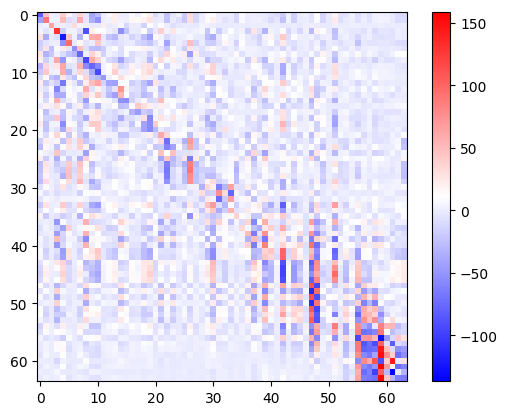

In [11]:
plot = plt.imshow((supp_vec_0.transpose(1, 2) @ evecs_flip_0)[0].cpu(), cmap='bwr')
plt.colorbar(plot)
plt.show()

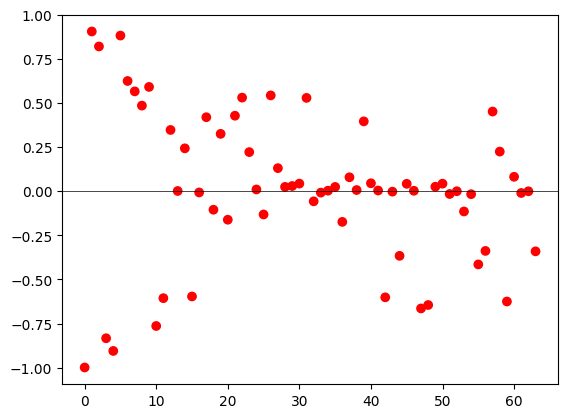

In [12]:
# marker color = blue if incorrect, red if correct
color = np.where(sign_correct.squeeze().detach().cpu().numpy() == 1, 'red', 'blue')

plt.scatter(np.arange(feature_dim), sign_diff_pred.squeeze().detach().cpu().numpy(), c=color)

plt.axhline(0, color='black', linewidth=0.5)
# plt.plot(sign_correct.squeeze().detach().cpu().numpy(), '.')

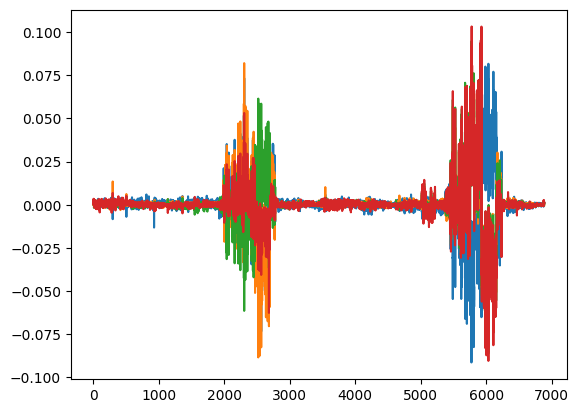

In [51]:
# fig, axs = plt.subplots(3, 1, figsize=(5, 10))

# for i, idx in enumerate(range(1, 4)):
#     axs[i].plot(supp_vec_0[0, :, -idx].cpu(), '-')
plt.plot(supp_vec_0[0, :, -4:].cpu(), '-')
plt.show()

In [ ]:
scene.geometry.clear()

verts = test_shape['verts'].cpu().numpy()
faces = test_shape['faces'].cpu().numpy()

cmap = np.ones((verts.shape[0], 4))

# set cmap to 1 where supp_vec_0[0, :, -4] > 0.02
cmap[supp_vec_0[0, :, -2].cpu().abs() > 0.015, :2] = 0
# cmap *= 255

mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_colors=cmap)
scene.add_geometry(mesh)

scene.show()

In [23]:
C_xy_pred_list = torch.tensor([])
C_xy_orig_list = torch.tensor([])
prod_with_support_list = torch.tensor([])
supp_vec_list = torch.tensor([])

data_0 = train_dataset[0]
verts_first = data_0['first']['verts'].unsqueeze(0).to(device)
evecs_first = data_0['first']['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
corr_first = data_0['first']['corr']

with torch.no_grad():
    sign_pred_first = predict_sign_change(net, verts_first, faces, evecs_first, 
                                        evecs_cond=None)[0]

for i in range(len(train_dataset)):
    # data_0 = test_dataset[12]
    data_0 = train_dataset[i]

    # verts_first = data_0['first']['verts'].unsqueeze(0).to(device)
    verts_second = data_0['second']['verts'].unsqueeze(0).to(device)

    # evecs_first = data_0['first']['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    evecs_second = data_0['second']['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)

    # corr_first = data_0['first']['corr']
    corr_second = data_0['second']['corr']

    C_gt_xy = data_0['second']['C_gt_xy'][0]

    # predict the sign change
    with torch.no_grad():
        # sign_pred_first = predict_sign_change(net, verts_first, faces, evecs_first, 
        #                                         evecs_cond=None)[0]
        sign_pred_second, supp_vec, prod_with_support = predict_sign_change(net, verts_second, faces, evecs_second, 
                                                evecs_cond=None)

    C_xy_pred = torch.linalg.lstsq(
        evecs_second.cpu()[0, corr_second] * torch.sign(sign_pred_second).cpu(),
        evecs_first.cpu()[0, corr_first] * torch.sign(sign_pred_first).cpu()
        ).solution
    
    C_xy_pred_list = torch.cat([C_xy_pred_list, C_xy_pred.unsqueeze(0)])
    C_xy_orig_list = torch.cat([C_xy_orig_list, C_gt_xy.unsqueeze(0)])
    prod_with_support_list = torch.cat([prod_with_support_list, prod_with_support.cpu()])
    supp_vec_list = torch.cat([supp_vec_list, supp_vec.cpu()])


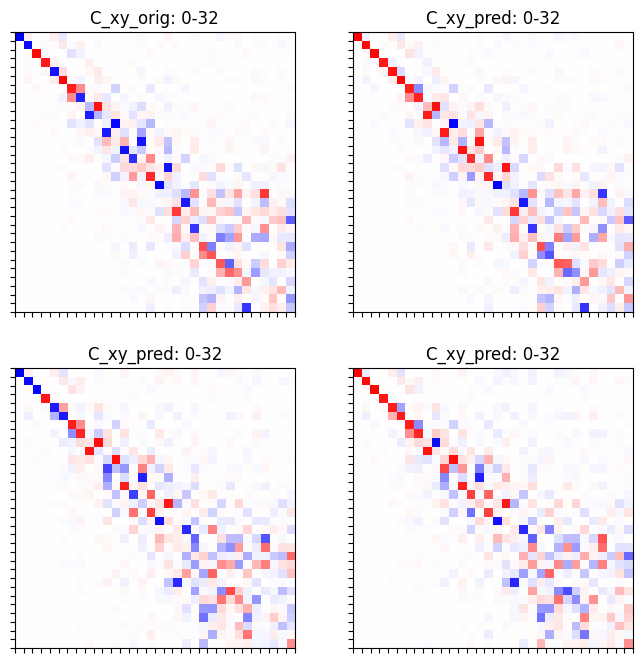

In [25]:
l = 0
h = 32

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plotting_utils.plot_Cxy(fig, axs[0, 0], C_xy_orig_list[11], 'C_xy_orig', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 1], C_xy_pred_list[11], 'C_xy_pred', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[1, 0], C_xy_orig_list[12], 'C_xy_pred', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 1], C_xy_pred_list[12], 'C_xy_pred', l, h, show_grid=False, show_colorbar=False)


plt.show()

PCA on predicted


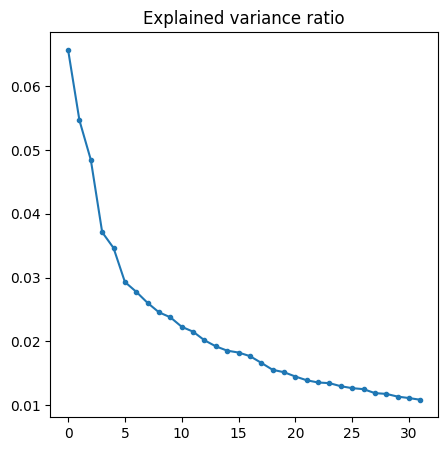

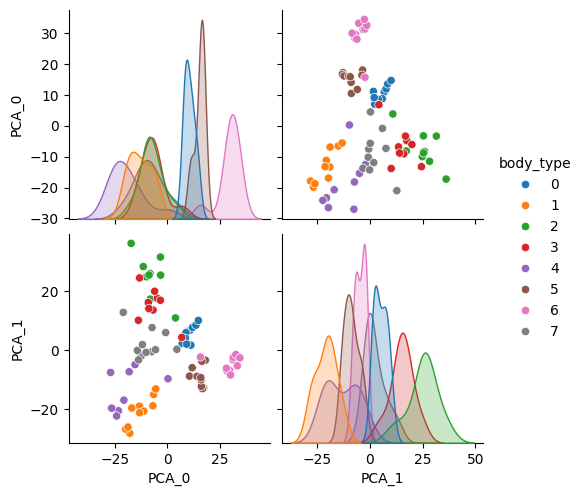

In [37]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

C_xy_pred_list_scaled = scaler.fit_transform(C_xy_pred_list.reshape(C_xy_pred_list.shape[0], -1))
C_xy_pred_list_pca = pca.fit_transform(C_xy_pred_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(C_xy_pred_list_pca[:, :2], columns=[f'PCA_{i}' for i in range(2)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(C_xy_pred_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_pred_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on predicted')
plt.show()



PCA on original


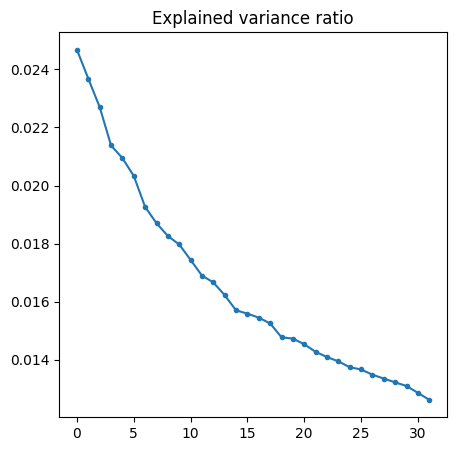

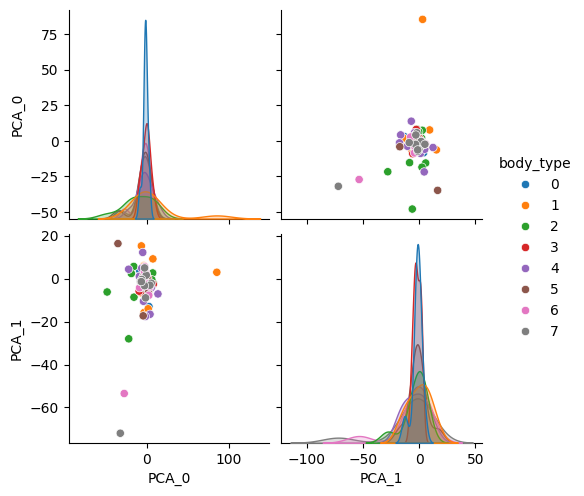

In [36]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

C_xy_orig_list_scaled = scaler.fit_transform(C_xy_orig_list.reshape(C_xy_orig_list.shape[0], -1))
C_xy_orig_list_pca = pca.fit_transform(C_xy_orig_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(C_xy_orig_list_pca[:, :2], columns=[f'PCA_{i}' for i in range(2)])

# remove the outliers based on standard deviation
# pca_df = pca_df[(np.abs(pca_df) < 50).all(axis=1)]


# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(C_xy_orig_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_orig_list_pca.shape[0])]

pca_df = pca_df[(np.abs(pca_df) < np.std(pca_df) * 6
                 ).all(axis=1)]

# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on original')
plt.show()



In [ ]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

prod_with_support_list_scaled = scaler.fit_transform(prod_with_support_list.reshape(prod_with_support_list.shape[0], -1))
prod_with_support_list_pca = pca.fit_transform(prod_with_support_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(prod_with_support_list_pca[:, :3], columns=[f'PCA_{i}' for i in range(3)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(prod_with_support_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_orig_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on product with support')
plt.show()



In [51]:
supp_vec_list.shape

torch.Size([80, 6890, 64])

In [ ]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

# supp_vec_list_scaled = scaler.fit_transform(supp_vec_list.reshape(supp_vec_list.shape[0], -1))
# supp_vec_list_pca = pca.fit_transform(supp_vec_list_scaled)

supp_vec_list_scaled = scaler.fit_transform(
    (supp_vec_list.transpose(1, 2) @ supp_vec_list).reshape(supp_vec_list.shape[0], -1)
    )
supp_vec_list_pca = pca.fit_transform(supp_vec_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(supp_vec_list_pca[:, :3], columns=[f'PCA_{i}' for i in range(3)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(supp_vec_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_orig_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on product with support')
plt.show()



In [ ]:
# supp_vec_list_product = supp_vec_list.transpose(1, 2) @ supp_vec_list
supp_vec_list_product = supp_vec_list_scaled.reshape(supp_vec_list.shape[0], feature_dim, feature_dim)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs_0 = axs[0].imshow(supp_vec_list_product[5], cmap='bwr')
plt.colorbar(axs_0, ax=axs[0])

axs_1 = axs[1].imshow(supp_vec_list_product[6], cmap='bwr')
plt.colorbar(axs_1, ax=axs[1])

axs_2 = axs[2].imshow(supp_vec_list_product[7], cmap='bwr')
plt.colorbar(axs_2, ax=axs[2])

plt.show()

PCA on product with support


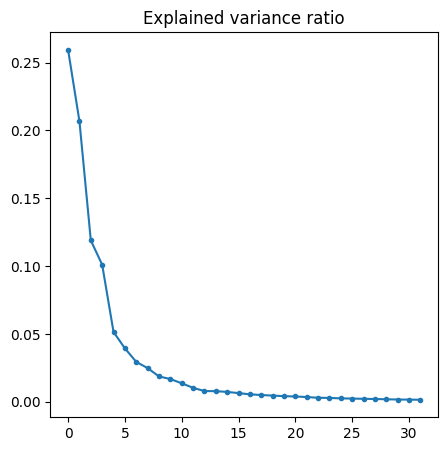

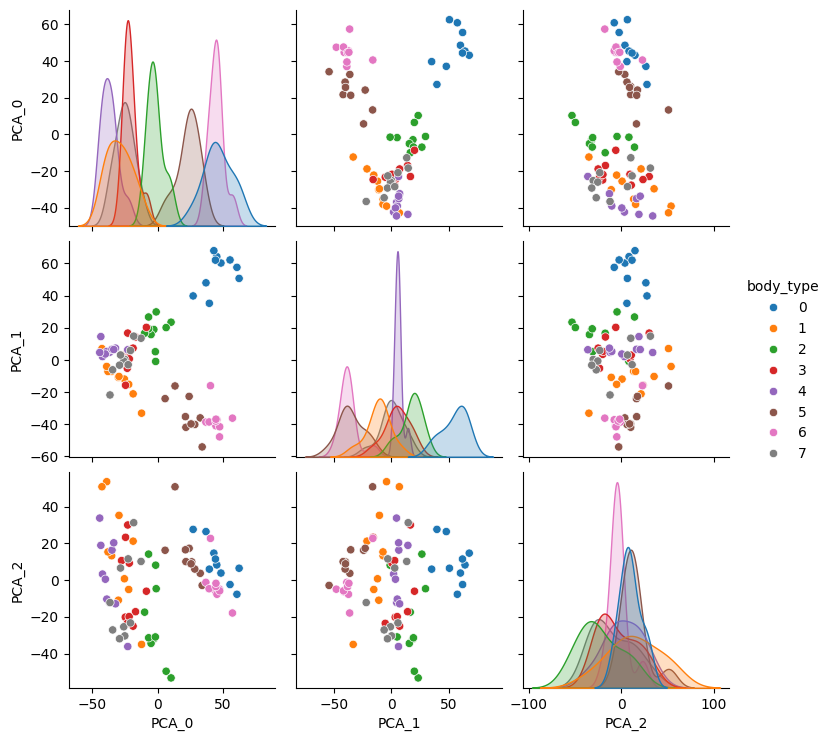

In [65]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

# supp_vec_list_scaled = scaler.fit_transform(supp_vec_list.reshape(supp_vec_list.shape[0], -1))
# supp_vec_list_pca = pca.fit_transform(supp_vec_list_scaled)

supp_vec_list_scaled = scaler.fit_transform(
    (supp_vec_list.transpose(1, 2) @ supp_vec_list).reshape(supp_vec_list.shape[0], -1)
    )
supp_vec_list_pca = pca.fit_transform(supp_vec_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(supp_vec_list_pca[:, :3], columns=[f'PCA_{i}' for i in range(3)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(supp_vec_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_orig_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on product with support')
plt.show()

